In [1]:
# from datagenerator import jet_data_generator 
from datagenerator_realistic import jet_data_generator as realistic_generator

from plotutils import plot_event 
import matplotlib.pyplot as plt
import time
import torch
import pandas as pd

In [2]:
import os
import numpy as np
# if not os.path.exists(os.path.join(os.getcwd(),'figures/paper')):
#     os.mkdir(os.path.join(os.getcwd(),'figures/paper'))

In [3]:
def delta_hyp(dismat):
    p = 0
    row = dismat[p, :][None, :]
    col = dismat[:, p][:, None]
    XY_p = 0.5 * (row + col - dismat)
    maxmin = torch.minimum(XY_p[:, :, None], XY_p[None, :, :]).max(1).values
    return (maxmin - XY_p).max()

In [15]:
# quark_mass = [2,5,10]
# n_parts = [16,32,64]
quark_mass = [10]
n_parts = [64]
num_samples = 100
# num_samples = 5
output_folder = "gromov_testing_datasets"
# os.mkdir(output_folder)


In [16]:
realistic_sig_2p_16part = realistic_generator("signal", 1, 32, True)
start = time.time()
dataset = realistic_sig_2p_16part.generate_dataset(num_samples)
end = time.time()



event : 0


/n/holystore01/LABS/iaifi_lab/Users/nswood/mambaforge/envs/flat-samples/lib/python3.10/site-packages/pylorentz/__init__.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self._values = np.array(list(x))
/n/home11/nswood/ToyJetGenerator/datagenerator_realistic.py:327: RuntimeWarning: invalid value encountered in sqrt
  return np.arctan(np.sqrt(num/den))
/n/home11/nswood/ToyJetGenerator/datagenerator_realistic.py:357: RuntimeWarning: invalid value encountered in sqrt
  zmin=np.maximum(0.2/mother.mom.p,0.5*(1-np.sqrt(1-(m/p)**2)))


In [17]:
gromov_outputs = []
data_samples = len(dataset[3])

for i in range(data_samples):
    all_particles = dataset[3][i]
    e_eta_phi = []

    for part in all_particles:
        mom = part.mom
        e_eta_phi.append([mom.e, mom.eta.item(), mom.phi.item()])

    e_eta_phi = np.array(e_eta_phi)
    four_momentum_tensor = torch.tensor(e_eta_phi)

    # Extract energy, eta, phi
    energies = four_momentum_tensor[:, 0]
    normalized_energies = energies / energies.sum()
    energies = normalized_energies
    etas = four_momentum_tensor[:, 1]
    phis = four_momentum_tensor[:, 2]

    # Compute pairwise energy differences
    energy_diffs = torch.abs(energies[:, None] - energies[None, :])
    delta_eta = etas[:, None] - etas[None, :]
    delta_phi = phis[:, None] - phis[None, :]
    delta_phi = torch.remainder(delta_phi + np.pi, 2 * np.pi) - np.pi
    delta_R = torch.sqrt(delta_eta ** 2 + delta_phi ** 2)

    R = 1
    dists = (energy_diffs * delta_R) / R
    delta = delta_hyp(dists)

    gromov_outputs.append({
        'delta': delta.item(),
        'n_parts': 32,
        'quark_mass': 1
    })
df = pd.DataFrame(gromov_outputs)
grouped = df.groupby(['n_parts', 'quark_mass'])
grouped.mean()

,,delta
n_parts,quark_mass,
32,1,0.072965


In [19]:
gromov_outputs = []
data_samples = len(dataset[3])

for i in range(data_samples):
    all_particles = dataset[4][i]
    e_eta_phi = []

    for part in all_particles:
        mom = part.mom
        e_eta_phi.append([mom.e, mom.eta.item(), mom.phi.item()])

    e_eta_phi = np.array(e_eta_phi)
    four_momentum_tensor = torch.tensor(e_eta_phi)

    # Extract energy, eta, phi
    energies = four_momentum_tensor[:, 0]
    normalized_energies = energies / energies.sum()
    energies = normalized_energies
    etas = four_momentum_tensor[:, 1]
    phis = four_momentum_tensor[:, 2]

    # Compute pairwise energy differences
    energy_diffs = torch.abs(energies[:, None] - energies[None, :])
    delta_eta = etas[:, None] - etas[None, :]
    delta_phi = phis[:, None] - phis[None, :]
    delta_phi = torch.remainder(delta_phi + np.pi, 2 * np.pi) - np.pi
    delta_R = torch.sqrt(delta_eta ** 2 + delta_phi ** 2)

    R = 1
    dists = (energy_diffs * delta_R) / R
    delta = delta_hyp(dists)

    gromov_outputs.append({
        'delta': delta.item(),
        'n_parts': 32,
        'quark_mass': 1
    })
df = pd.DataFrame(gromov_outputs)
grouped = df.groupby(['n_parts', 'quark_mass'])
grouped.mean()

,,delta
n_parts,quark_mass,
32,1,0.072479


In [32]:

def generate_and_save_datasets():
    for qmass in quark_mass:
        for npts in n_parts:
            realistic_sig_2p_16part = realistic_generator("signal", qmass, npts, True)
            start = time.time()
            dataset = realistic_sig_2p_16part.generate_dataset(num_samples)
            end = time.time()

            print(f"Generated dataset for quark mass {qmass}, n_parts {npts} in {end - start:.2f}s")

            # Save dataset to a folder with naming convention
            filename = f"{output_folder}/dataset_qmass{qmass}_nparts{npts}.pt"
            torch.save(dataset, filename)
            print(f"Saved to {filename}")

In [19]:
def process_datasets():
    gromov_outputs = []

    for qmass in quark_mass:
        for npts in n_parts:
            filename = f"{output_folder}/dataset_qmass{qmass}_nparts{npts}.pt"

            if os.path.exists(filename):
                dataset = torch.load(filename)
                data_samples = len(dataset[3])

                for i in range(data_samples):
                    all_particles = dataset[3][i]
                    e_eta_phi = []

                    for part in all_particles:
                        mom = part.mom
                        e_eta_phi.append([mom.e, mom.eta.item(), mom.phi.item()])

                    e_eta_phi = np.array(e_eta_phi)
                    four_momentum_tensor = torch.tensor(e_eta_phi)

                    # Extract energy, eta, phi
                    energies = four_momentum_tensor[:, 0]
                    normalized_energies = energies / energies.sum()
                    energies = normalized_energies
                    etas = four_momentum_tensor[:, 1]
                    phis = four_momentum_tensor[:, 2]

                    # Compute pairwise energy differences
                    energy_diffs = torch.abs(energies[:, None] - energies[None, :])
                    delta_eta = etas[:, None] - etas[None, :]
                    delta_phi = phis[:, None] - phis[None, :]
                    delta_phi = torch.remainder(delta_phi + np.pi, 2 * np.pi) - np.pi
                    delta_R = torch.sqrt(delta_eta ** 2 + delta_phi ** 2)

                    R = 1
                    dists = (energy_diffs * delta_R) / R
                    delta = delta_hyp(dists)

                    gromov_outputs.append({
                        'delta': delta.item(),
                        'n_parts': npts,
                        'quark_mass': qmass
                    })

            else:
                print(f"Dataset not found: {filename}")

    return gromov_outputs

In [ ]:
generate_and_save_datasets()

In [20]:
output = process_datasets()

Dataset not found: gromov_testing_datasets/dataset_qmass10_nparts64.pt


In [21]:
df = pd.DataFrame(output)
grouped = df.groupby(['n_parts', 'quark_mass'])
grouped.mean()

In [23]:
grouped = df.groupby(['n_parts', 'quark_mass'])


delta
n_parts quark_mass          
16      2           0.090119
        5           0.109431
        10          0.129188
32      2           0.076833
        5           0.093088
        10          0.111844
64      2           0.068073
        5           0.077296

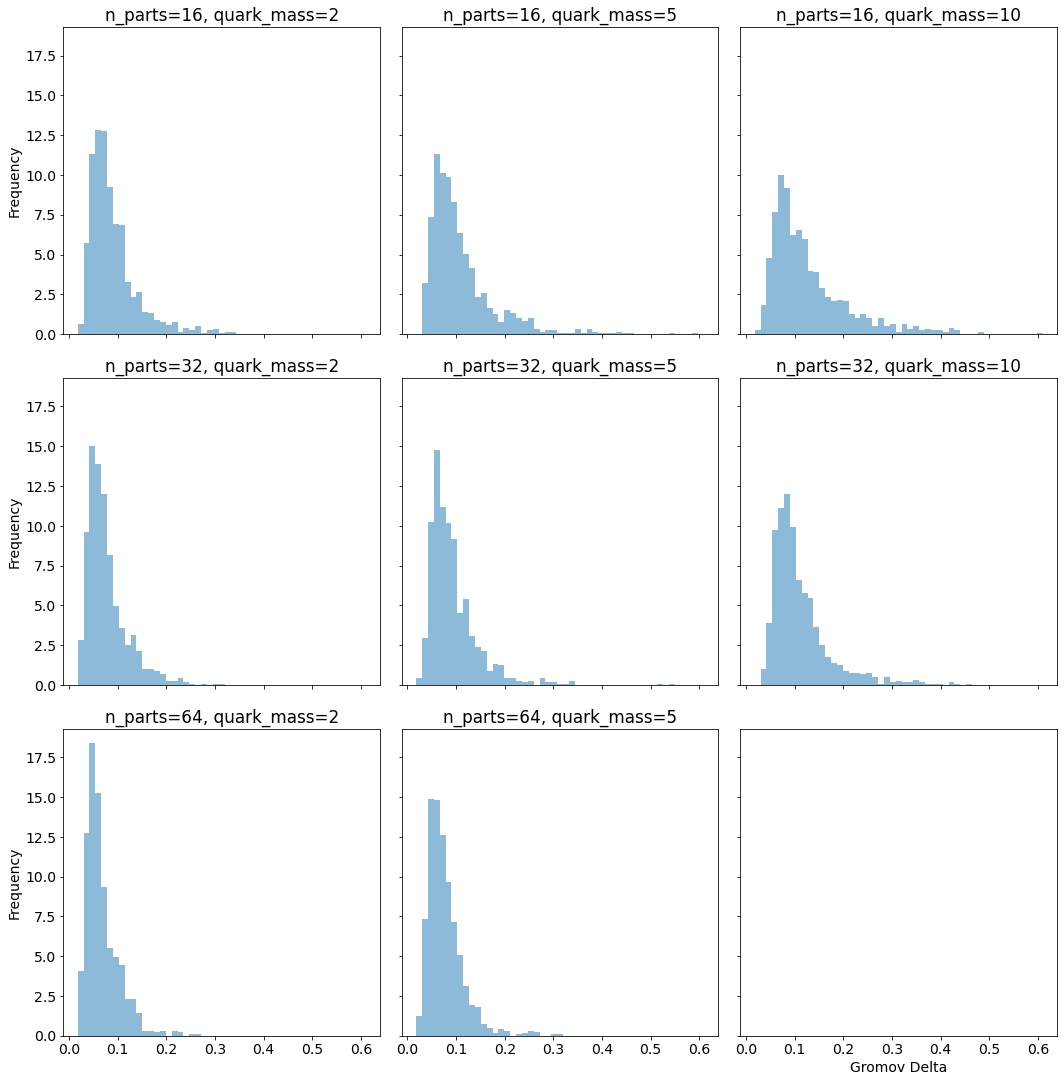

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15), sharex=True, sharey=True)
axes = axes.flatten()

bins = np.linspace(df['delta'].min(), df['delta'].max(), 50)

for ax, ((n_parts, quark_mass), group) in zip(axes, grouped):
    group['delta'].plot.hist(ax=ax, bins=bins, density=True, alpha=0.5)
    ax.set_title(f'n_parts={n_parts}, quark_mass={quark_mass}')
    
plt.tight_layout()
plt.xlabel('Gromov Delta')
plt.ylabel('Density')
plt.show()

,,delta
n_parts,quark_mass,
16,2,0.096976
32,2,0.057278
64,2,0.050756


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

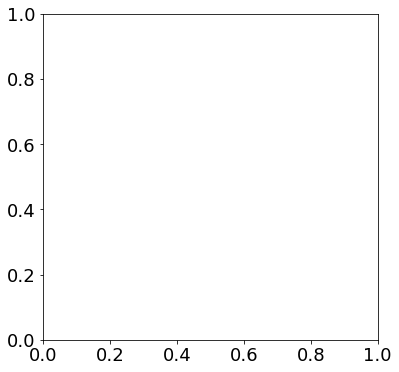

In [13]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(realisticdata_sig_2p_16part[1][:,0],alpha=0.4,bins=np.linspace(0,0.5,51),density=True,label="Hard Splitting")
ax.hist(realisticdata_sig_2p_16part[1][:,1],alpha=0.4,bins=np.linspace(0,0.5,51),density=True,label="Soft Splitting")
ax.legend()
ax.set_xlabel(r'$z_{g}$')
ax.set_ylabel('Density')
ax.set_yscale('log')
#fig.savefig('./figures/paper/realistic_toyjet_momentum_sharing_Log.png')
#fig.savefig('./figures/paper/realistic_toyjet_momentum_sharing_Log.pdf')

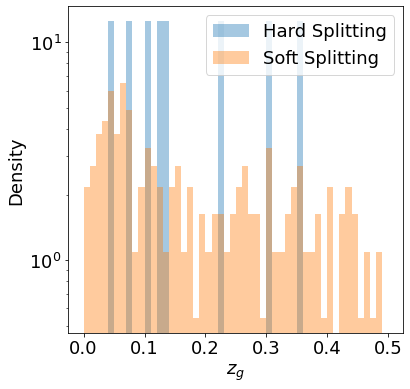

In [14]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(realistic_sig_2p_16part.zhard,alpha=0.4,bins=np.linspace(0,0.5,51),density=True,label="Hard Splitting")
ax.hist(realistic_sig_2p_16part.zsoft,alpha=0.4,bins=np.linspace(0,0.5,51),density=True,label="Soft Splitting")
ax.legend()
ax.set_xlabel(r'$z_{g}$')
ax.set_ylabel('Density')
ax.set_yscale('log')
fig.savefig('./figures/paper/realistic_toyjet_momentum_sharing_Log.png')
fig.savefig('./figures/paper/realistic_toyjet_momentum_sharing_Log.pdf')

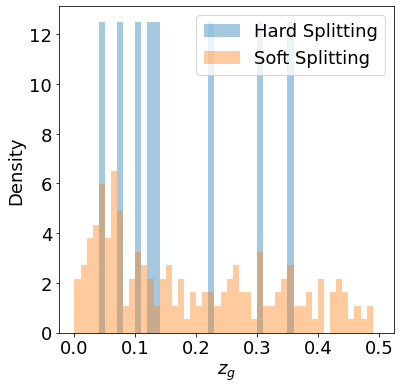

In [15]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(realistic_sig_2p_16part.zhard,alpha=0.4,bins=np.linspace(0,0.5,51),density=True,label="Hard Splitting")
ax.hist(realistic_sig_2p_16part.zsoft,alpha=0.4,bins=np.linspace(0,0.5,51),density=True,label="Soft Splitting")
ax.legend()
ax.set_xlabel(r'$z_{g}$')
ax.set_ylabel('Density')
fig.savefig('./figures/paper/realistic_toyjet_momentum_sharing.png')
fig.savefig('./figures/paper/realistic_toyjet_momentum_sharing.pdf')

In [22]:
import matplotlib as mpl
import matplotlib.font_manager as font_manager

mpl.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False
mpl.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt

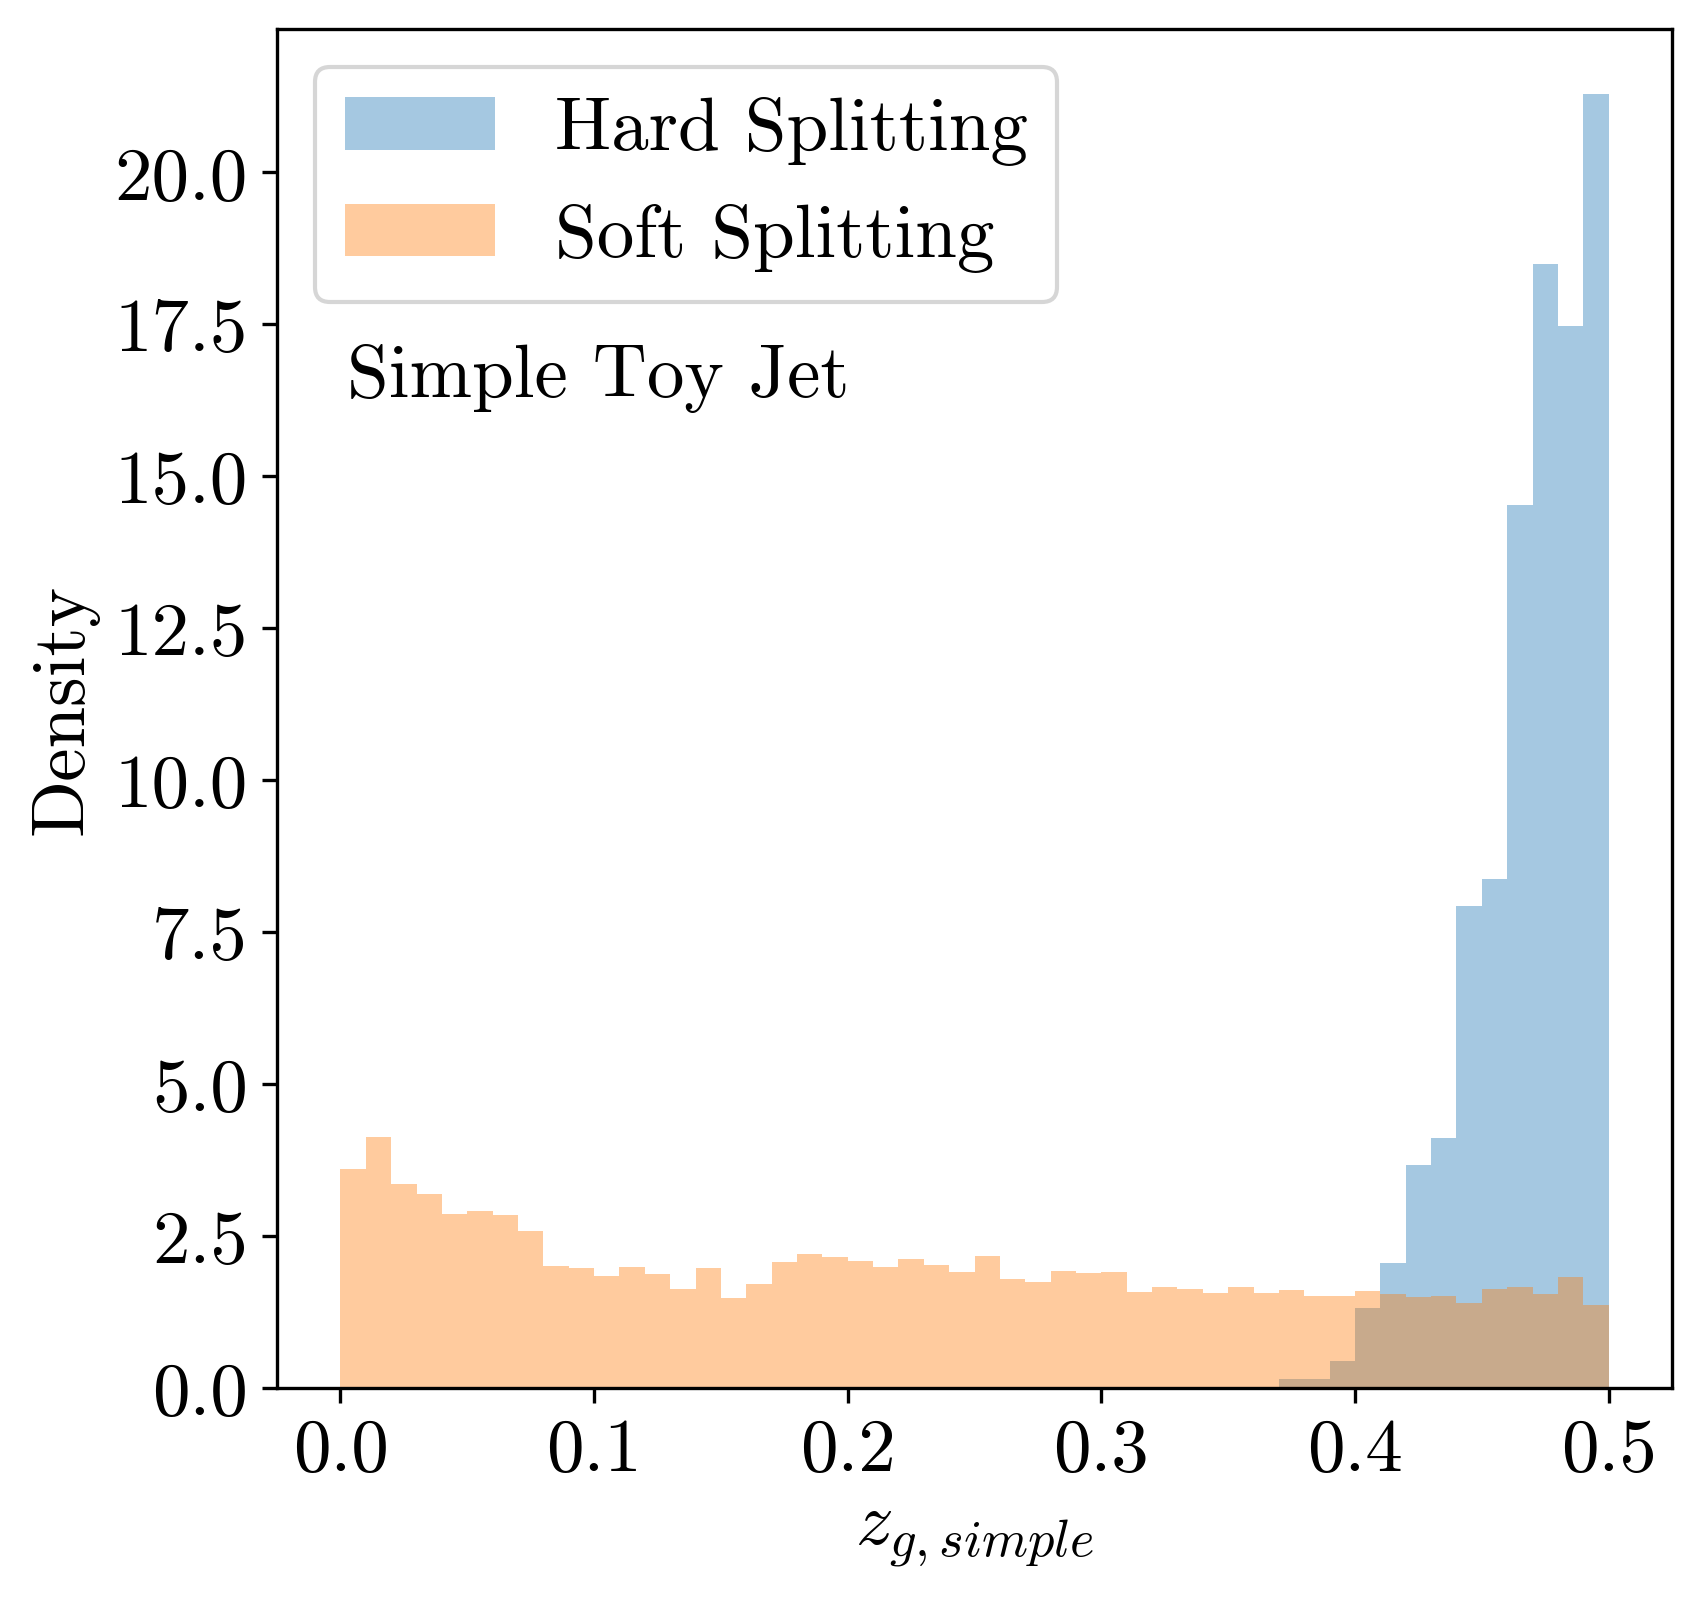

In [23]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(simple_sig_2p_16part.zhard,alpha=0.4,bins=np.linspace(0,0.5,51),density=True,label="Hard Splitting")
ax.hist(simple_sig_2p_16part.zsoft,alpha=0.4,bins=np.linspace(0,0.5,51),density=True,label="Soft Splitting")
ax.legend()
ax.set_xlabel(r'$z_{g, simple}$')
ax.set_ylabel('Density')
ax.text(0.05, 0.73, 'Simple Toy Jet', transform=ax.transAxes)

fig.savefig('./figures/paper_JHEP/SimpleToyJet_Zg.png')
fig.savefig('./figures/paper_JHEP/SimpleToyJet_Zg.pdf')

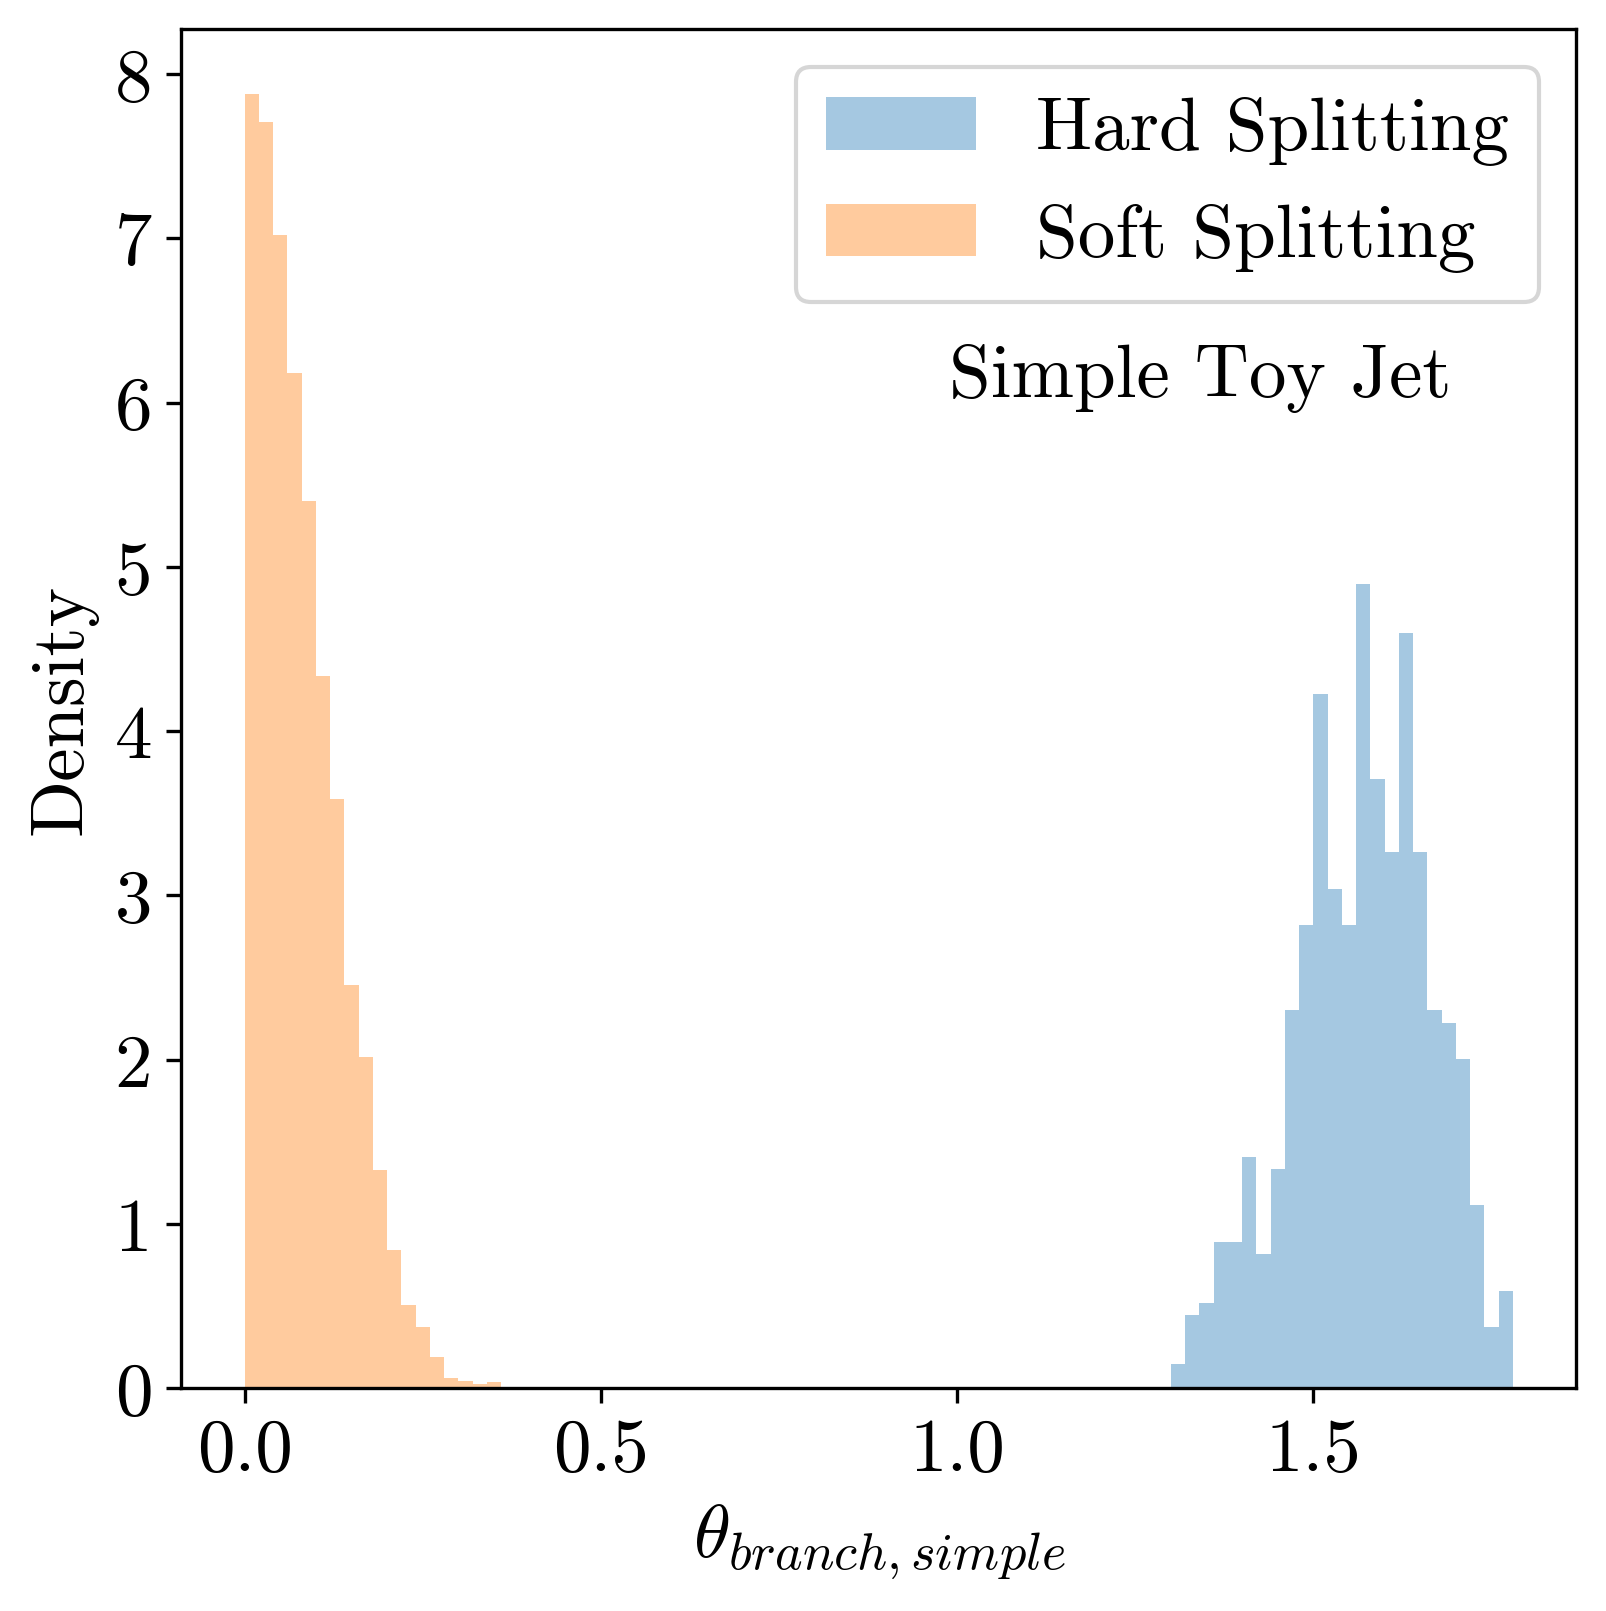

In [24]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(simple_sig_2p_16part.thetahard,alpha=0.4,bins=np.arange(0,1.8,0.02),density=True,label="Hard Splitting")
ax.hist(simple_sig_2p_16part.thetasoft,alpha=0.4,bins=np.arange(0,1.8,0.02),density=True,label="Soft Splitting")
ax.legend()
ax.set_xlabel(r'$\theta_{branch, simple}$')
ax.set_ylabel('Density')
ax.text(0.55, 0.73, 'Simple Toy Jet', transform=ax.transAxes)

fig.savefig('./figures/paper_JHEP/SimpleToyJet_Theta.png')
fig.savefig('./figures/paper_JHEP/SimpleToyJet_Theta.pdf')

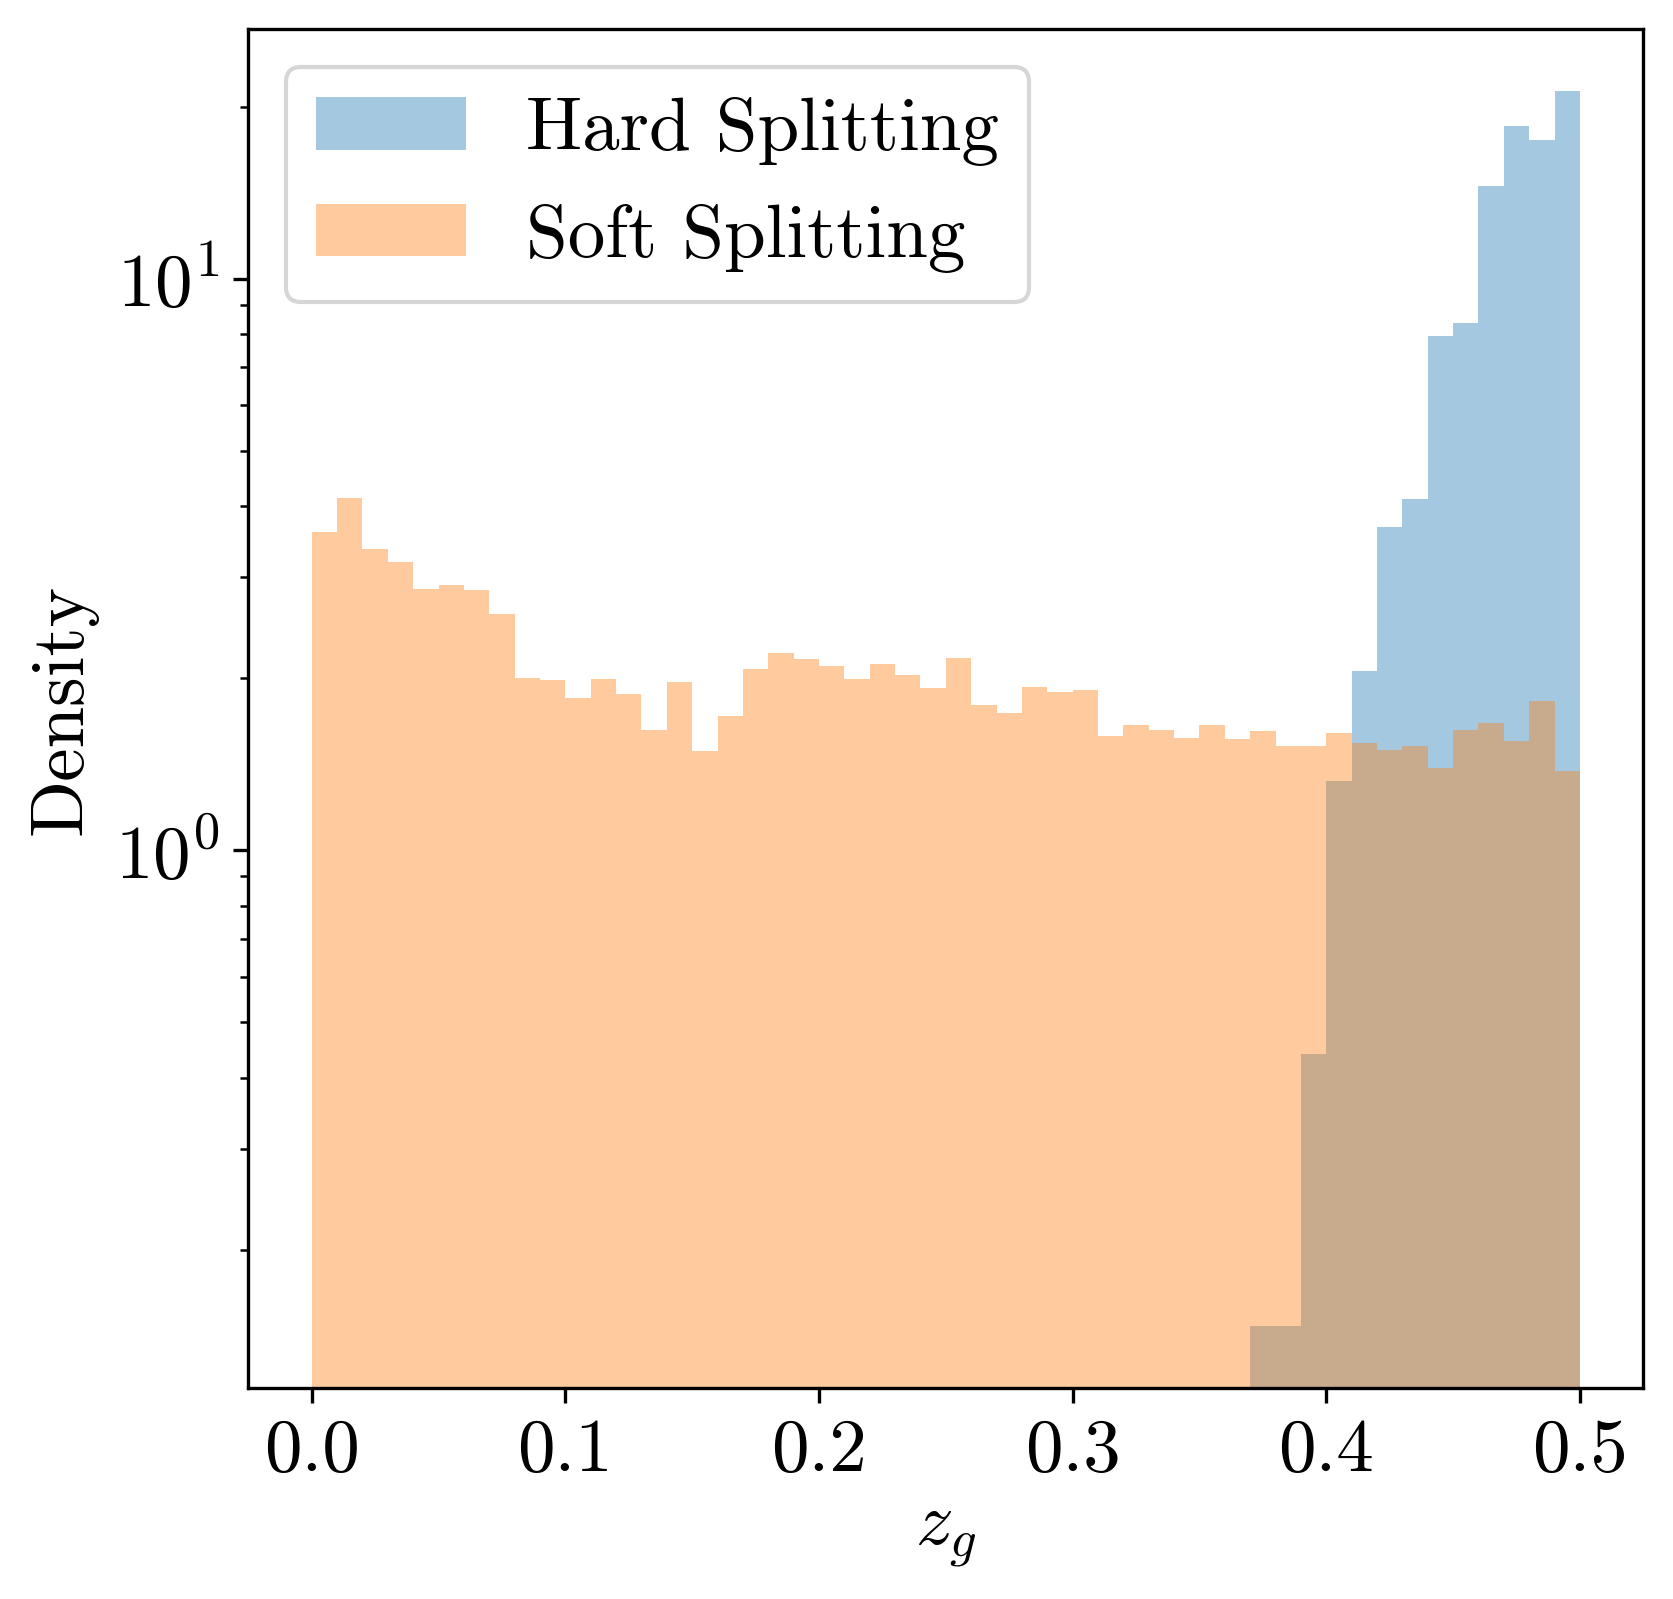

In [25]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(simple_sig_2p_16part.zhard,alpha=0.4,bins=np.linspace(0,0.5,51),density=True,label="Hard Splitting")
ax.hist(simple_sig_2p_16part.zsoft,alpha=0.4,bins=np.linspace(0,0.5,51),density=True,label="Soft Splitting")
ax.legend()
ax.set_xlabel(r'$z_{g}$')
ax.set_ylabel('Density')
ax.set_yscale('log')

fig.savefig('./figures/paper/simple_toyjet_momentum_sharing_Log.png')
fig.savefig('./figures/paper/simple_toyjet_momentum_sharing_Log.pdf')

Text(0, 0.5, 'Density')

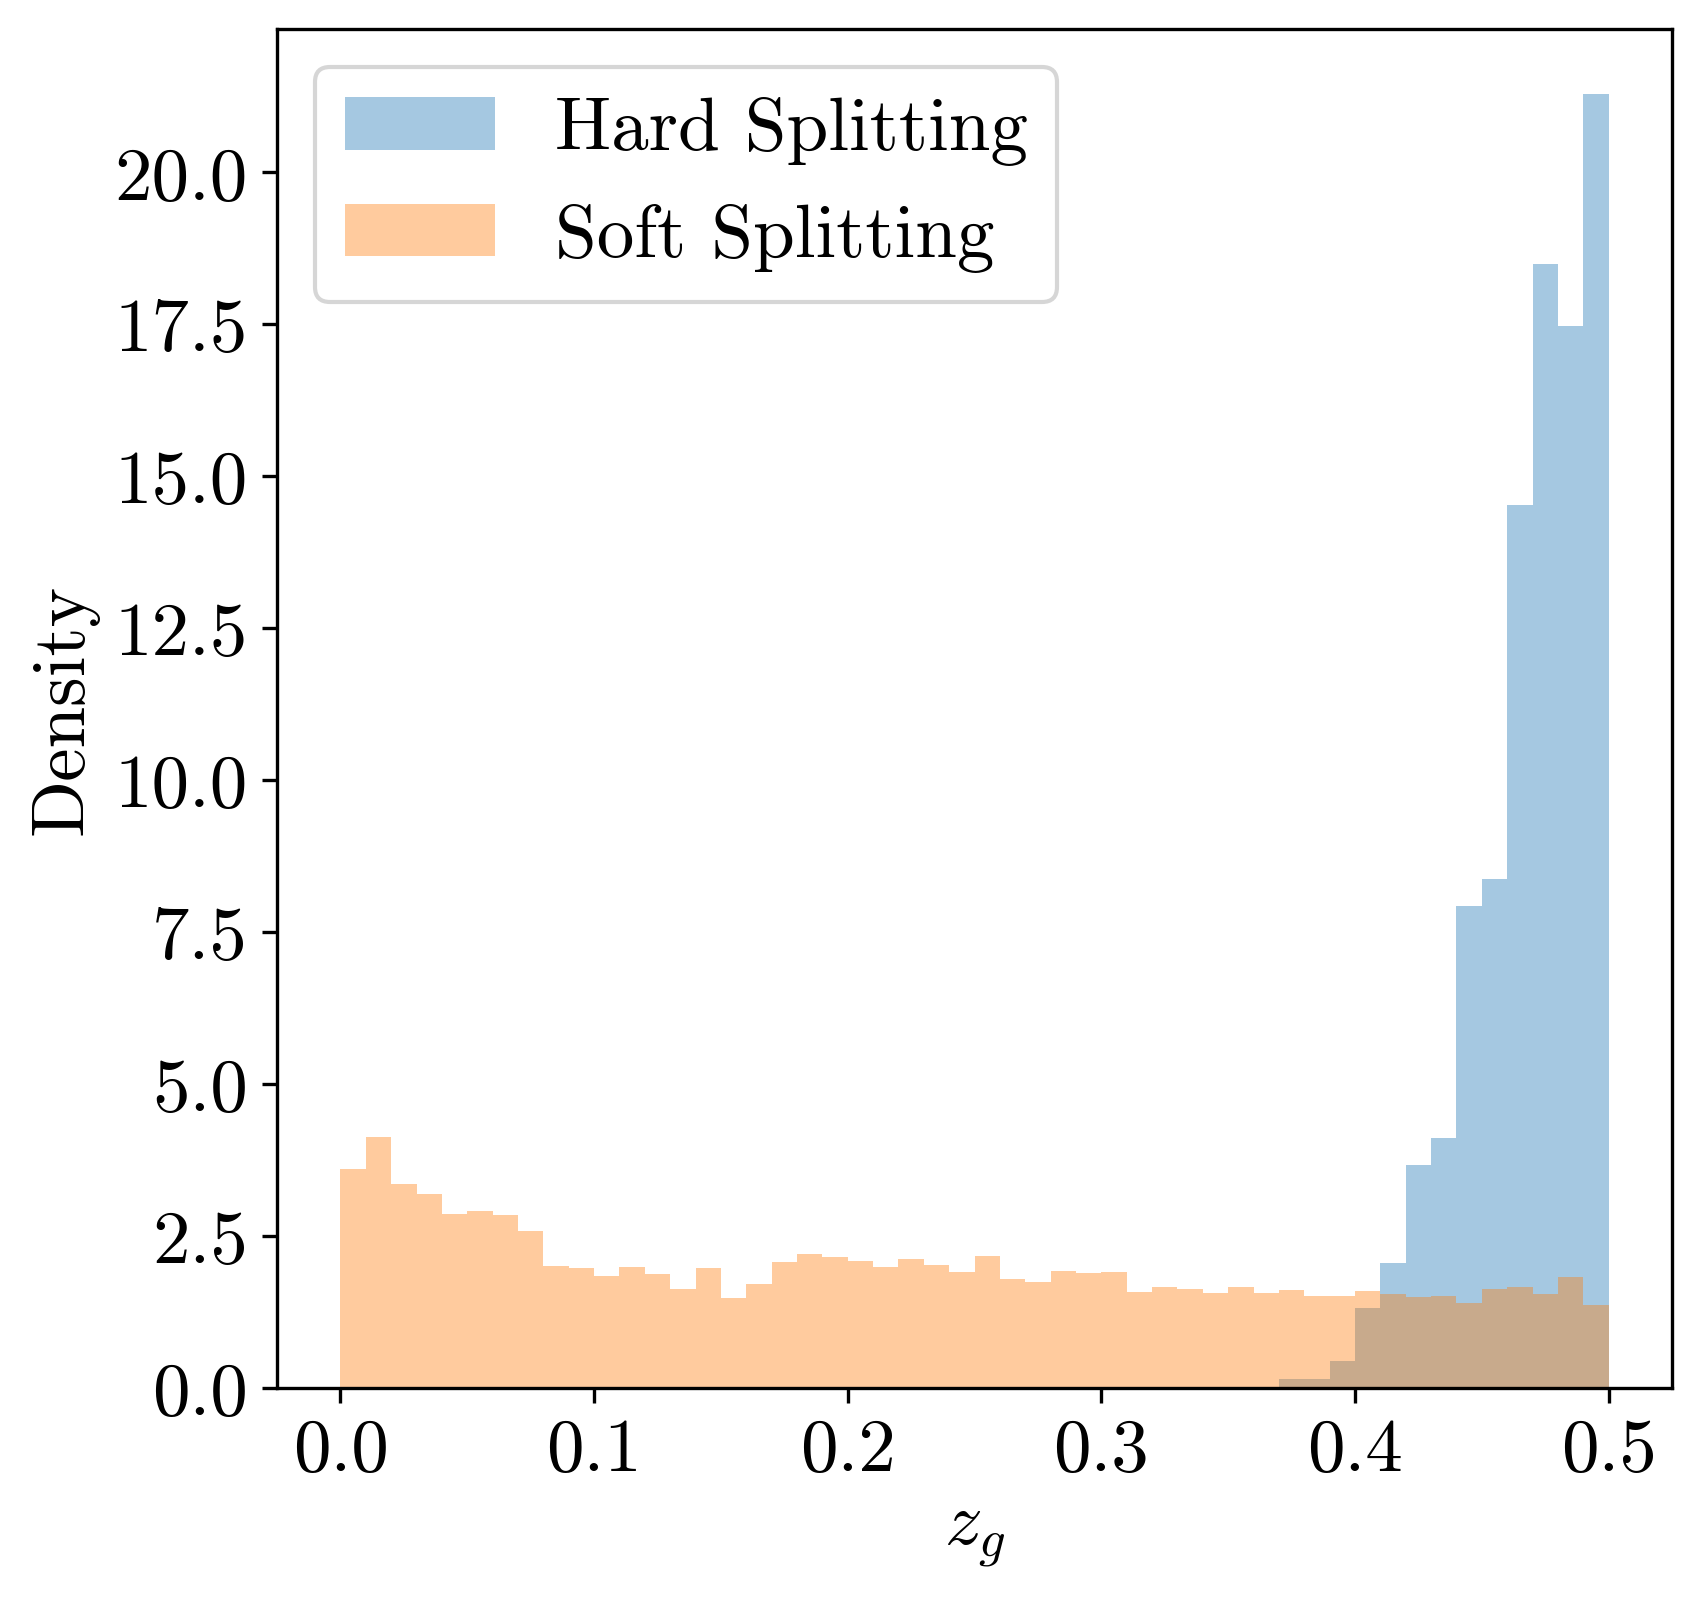

In [26]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(simple_sig_2p_16part.zhard,alpha=0.4,bins=np.linspace(0,0.5,51),density=True,label="Hard Splitting")
ax.hist(simple_sig_2p_16part.zsoft,alpha=0.4,bins=np.linspace(0,0.5,51),density=True,label="Soft Splitting")
ax.legend()
ax.set_xlabel(r'$z_{g}$')
ax.set_ylabel('Density')
#fig.savefig('./figures/paper/simple_toyjet_momentum_sharing.png')
#fig.savefig('./figures/paper/simple_toyjet_momentum_sharing.pdf')

In [27]:
data_sig_2p_8part.shape

NameError: name 'data_sig_2p_8part' is not defined

In [48]:
def plot_event(pfcands, name):

    pt = pfcands[:,0]
    eta = pfcands[:,1]
    phi = pfcands[:,2]
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.scatter(eta,phi,s=pt*10, alpha=0.2)
    ax.set_xlabel('eta')
    ax.set_ylabel('phi')
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    fig.savefig(f'figures/{name}.png')
plot_event(data_sig_3p_8part[99].reshape(-1,3), "top_3p_8part")

In [50]:
sig_3p_8part = jet_data_generator("signal",0.00005, 3, 8, True)

In [51]:
data_sig_3p_8part = sig_3p_8part.generate_dataset(100)

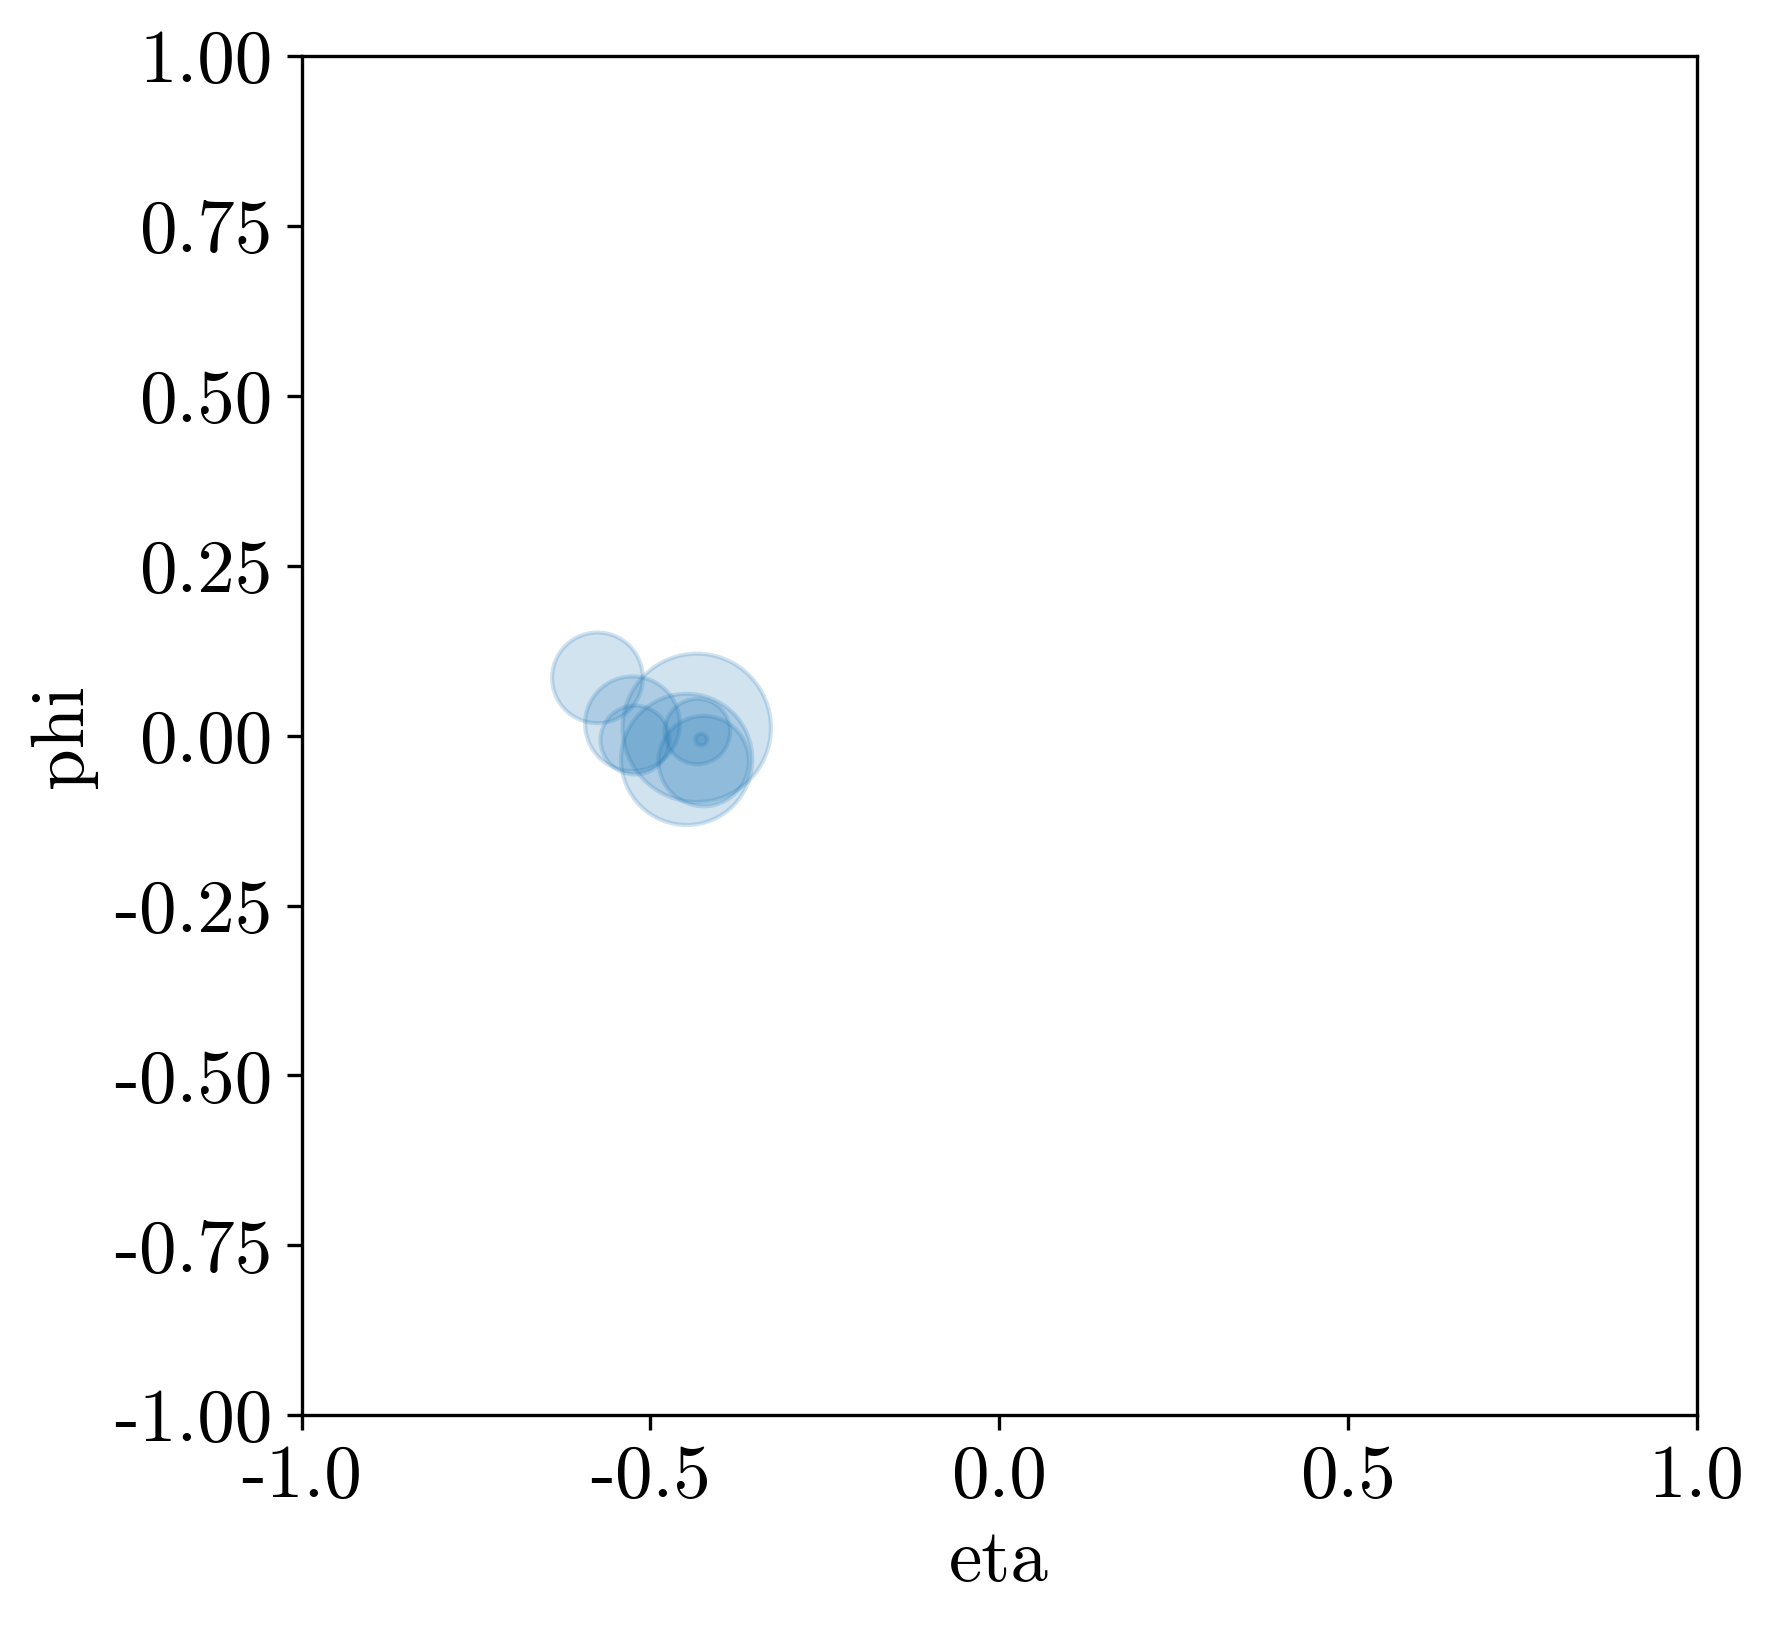

In [55]:
plot_event(data_sig_3p_8part[99].reshape(-1,3), "top_3p_8part")

In [ ]:
start = time.time()
data_sig_2p_2part = sig_2p_2part.generate_dataset(100)
end = time.time()
print(end-start)

In [ ]:
plot_event(data_sig_2p_2part[5].reshape(-1,3), "sig_2p_2part")

In [ ]:
sig_2p_3part = jet_data_generator("signal",0.00005, 2, 3)

In [ ]:
data_sig_2p_3part = sig_2p_3part.generate_dataset(100)


In [ ]:
plot_event(data_sig_2p_3part[5].reshape(-1,3), "sig_2p_3part")

In [ ]:
sig_3p_3part = jet_data_generator("signal",0.00005, 3, 3)

In [ ]:
data_sig_3p_3part = sig_3p_3part.generate_dataset(100)


In [ ]:
plot_event(data_sig_3p_3part[1].reshape(-1,3), "sig_3p_3part")

## 